# Reading SNANA Data

In this notebook we look at how we can read in SED templates generated by SNANA and simulate them under different observing cadences and noise conditions.

In [12]:
import numpy as np

from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc
from lightcurvelynx.math_nodes.ra_dec_sampler import ApproximateMOCSampler
from lightcurvelynx.obstable.opsim import OpSim
from lightcurvelynx.simulate import simulate_lightcurves
from lightcurvelynx.models.sed_template_model import SIMSEDModel
from lightcurvelynx.utils.plotting import plot_lightcurves

## Load Data Files

We start by loading the files we will need for running the simulation: the ObsTable of survey information and the passband information. Both of these live in the `data/` directory in the root directory. Note that nothing in this directory is saved to github, so the files will need to be manaully downloaded initially.

For Rubin, a large number of OpSims can be found at [https://s3df.slac.stanford.edu/data/rubin/sim-data/](https://s3df.slac.stanford.edu/data/rubin/sim-data/). You can download an OpSim manually or using the `from_url()` helper function:

> opsim_url = "https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.4/baseline/baseline_v3.4_10yrs.db"

> opsim_data = OpSim.from_url(opsim_url)

In this example we use an artificial opsim that looks at the same region of sky every night for 3 months (Jan 1, 2027 through April 1, 2027). Using a rotation of the "g", "r", "i", and "z" filters.

In [13]:
filters_options = ["g", "r", "i", "z"]

times = np.arange(61406, 61496, 1)
values = {
    "observationStartMJD": np.array(times),
    "fieldRA": np.full(len(times), 30.0),  # Fixed RA for all viewings
    "fieldDec": np.full(len(times), -30.0),  # Fixed dec for all viewings
    "zp_nJy": np.random.normal(loc=0.6, scale=0.1, size=len(times)),  # Random zeropoint around 0.6 nJy
    "seeingFwhmEff": np.random.normal(
        loc=1.2, scale=0.1, size=len(times)
    ),  # Random seeing FWHM around 1.2 arcsec
    "skyBrightness": np.random.normal(
        loc=21.0, scale=0.5, size=len(times)
    ),  # Random sky brightness around 21 mag/arcsec^2
    "nexposure": np.full(len(times), 2),  # 2 exposures per visit
    "exptime": np.full(len(times), 30.0),  # 30 second exposures
    "filter": np.array([filters_options[i % 4] for i in range(len(times))]),
}
opsim_db = OpSim(values)

Load the passband information, using the same filters. For most models the passband information will be used to convert the SED into bandfluxes. However, since we already have light curves at the bandflux level, we will just generate observations directly from those.

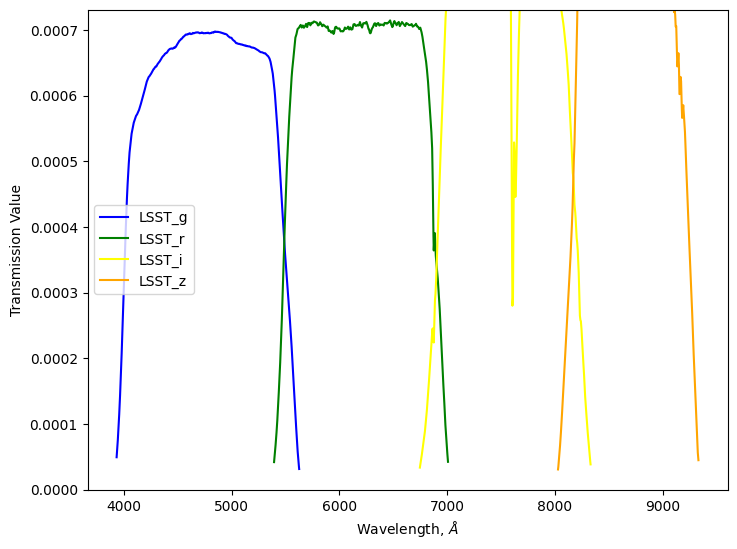

In [14]:
# Load the passband data for the griz filters only.
table_dir = _LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    filters=["g", "r", "i", "z"],
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)
passband_group.plot()

## Create the model

We want to create models based on SED-level data generated by SNANA. In this example we use the SIMSED.SNIbc-MOSFIT data set from https://zenodo.org/records/2612896 which contains around 700 SED templates in SIMSED format. Note that this data is not stored in the github repository and must be downloaded separately from zenodo.

Each template consists of sampled SED values (in erg/cm²/s/Å as seen from 10 pc in rest-frame) for a grid of times and wavelengths. An additional SED.INFO provides global information for the templates, such as the flux scaling factor. LightCurveLynx handles all the internal conversions, so results are produced in the same units as other models (nJy).

The `SIMSEDModel` object loads each SED template in a target directory. It also reads the corresponding SED.INFO file to extract relevant data set wide parameters, such as the flux scaling factor. New observations are created by randomly choosing one of the SED templates and interpolating it the query times and wavelengths. The starting time of the activity is controlled by the `t0` parameter in the model. So we can generate a simulation where the object's activity starts halfway through our observations.

Since `SIMSEDModel` is a `PhysicalModel`, we can specify other parameters such as the RA and dec.  In this examples, we generate this position information by sampling from the OpSim fields (using an `ApproximateMOCSampler` node). We sample the starting time of the event within the first 20 days of the survey coverage.

In [15]:
# We create the sampling area using a MOC that covers the region observed in the OpSim.
coverage_moc = opsim_db.build_moc(radius=1.0)  # 1 degree radius around each field center
ra_dec_sampler = ApproximateMOCSampler(coverage_moc)

# Use a uniform sampler for the starting time (t0) of activity. All events will
# start within the first 20 days of the survey (between MJD 61406 and 61426).
time_sampler = NumpyRandomFunc("uniform", low=61406, high=61426, node_label="time_sampler")

source = SIMSEDModel.from_dir(
    # The directory containing the SIMSED files.
    _LIGHTCURVELYNX_BASE_DATA_DIR / "model_files" / "SIMSED.SNIbc-MOSFIT",
    # The other parameters for the model.
    ra=ra_dec_sampler.ra,
    dec=ra_dec_sampler.dec,
    t0=time_sampler,
    node_label="source",
    distance=10.0,  # 10 pc
)

print(f"Loaded {len(source)} templates.")

Loaded 699 templates.


## Generate the simulations

We can now generate random simulations with all the information defined above. The `simulate_lightcurves` function takes three parameters: the source from which we want to sample (here the collection of SED templates), the number of results to simulate (1,000), and the passband information.

In [16]:
lightcurves = simulate_lightcurves(source, 1_000, opsim_db, passband_group)

Simulating: 100%|██████████| 1000/1000 [00:01<00:00, 523.45obj/s]


The results are written in the [nested-pandas](https://github.com/lincc-frameworks/nested-pandas) format for easy analysis. Each row corresponds to a single simulated object, with a unique id, ra, dec, etc. The column `params` include all internal state, including hyperparameter settings, that was used to generate this object. The nested `lightcurve` column contains the times, filters, and fluxes for each observation of that object.

We can extract the light curve for a single simulated object and plot it.

<Axes: xlabel='Time (MJD)', ylabel='Flux (nJy)'>

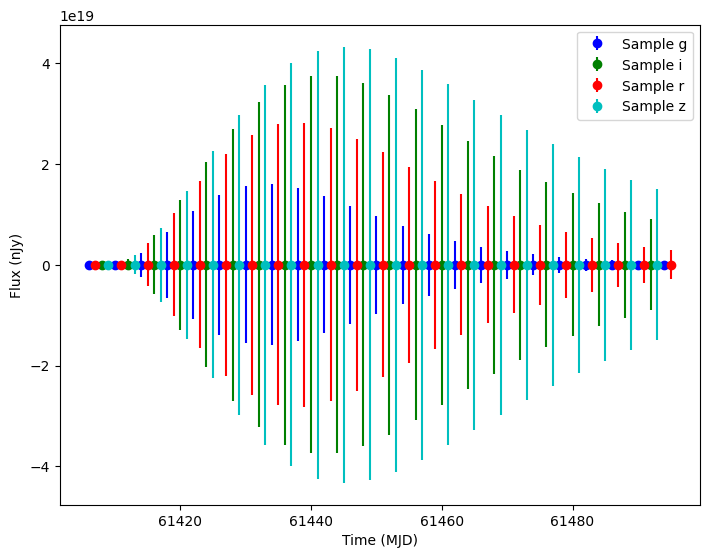

In [17]:
lightcurve0 = lightcurves.iloc[0]["lightcurve"]
plot_lightcurves(
    fluxes=np.asarray(lightcurve0["flux"], dtype=float),
    times=np.asarray(lightcurve0["mjd"], dtype=float),
    fluxerrs=np.asarray(lightcurve0["fluxerr"], dtype=float),
    filters=np.asarray(lightcurve0["filter"], dtype=str),
)